In [1]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


KeyboardInterrupt: 

In [ ]:
!unzip -q /content/data.zip -d /content/data

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
csv_path = "/content/data/data/driving_log.csv"
df = pd.read_csv(csv_path, header=None)

image_paths = [
    os.path.join("/content/data/data/IMG", os.path.basename(p.strip().replace('\\', '/')))
    for p in df[0]
]

steering_angles = df[3].astype('float32')

# Train-test split
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    image_paths, steering_angles, test_size=0.2, random_state=42
)

print(f"Train samples: {len(X_train_paths)}, Test samples: {len(X_test_paths)}")


Train samples: 9788, Test samples: 2448


In [ ]:
def preprocess_image(img):
    img = img[60:135, :, :]  # Crop
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)  # YUV
    img = cv2.resize(img, (200, 66))  # Resize
    img = cv2.GaussianBlur(img, (3, 3), 0)  # Blur
    return img.astype('float32') / 255.0  # Normalize

def augment_image(img, angle):
    # Flip
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        angle = -angle

    # Brightness
    if np.random.rand() < 0.5:
        hsv = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_YUV2BGR)
        hsv = cv2.cvtColor(hsv, cv2.COLOR_BGR2HSV)
        hsv[:, :, 2] = hsv[:, :, 2] * (0.5 + np.random.uniform())
        hsv = np.clip(hsv, 0, 255)
        img = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV) / 255.0

    # Zoom
    if np.random.rand() < 0.5:
        zoom_factor = 1 + np.random.uniform(0, 0.2)
        h, w = img.shape[:2]
        nh, nw = int(h / zoom_factor), int(w / zoom_factor)
        y1, x1 = np.random.randint(0, h - nh), np.random.randint(0, w - nw)
        img = cv2.resize(img[y1:y1+nh, x1:x1+nw], (w, h))

    # Pan
    if np.random.rand() < 0.5:
        h, w = img.shape[:2]
        tx = np.random.randint(-20, 20)
        ty = np.random.randint(-10, 10)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        img = cv2.warpAffine(img, M, (w, h))

    # Rotation
    if np.random.rand() < 0.5:
        h, w = img.shape[:2]
        angle_rot = np.random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((w / 2, h / 2), angle_rot, 1)
        img = cv2.warpAffine(img, M, (w, h))

    return img, angle


In [ ]:
def train_generator(paths, angles, batch_size):
    while True:
        indices = np.arange(len(paths))
        np.random.shuffle(indices)
        for start in range(0, len(paths), batch_size):
            X_batch, y_batch = [], []
            for idx in indices[start:start+batch_size]:
                img = cv2.imread(paths[idx])
                img = preprocess_image(img)
                img, angle = augment_image(img, angles.iloc[idx])
                X_batch.append(img)
                y_batch.append(angle)
            yield np.array(X_batch), np.array(y_batch)

def val_generator(paths, angles, batch_size):
    while True:
        for start in range(0, len(paths), batch_size):
            X_batch, y_batch = [], []
            for idx in range(start, start+batch_size):
                img = cv2.imread(paths[idx])
                img = preprocess_image(img)
                X_batch.append(img)
                y_batch.append(angles.iloc[idx])
            yield np.array(X_batch), np.array(y_batch)


In [ ]:
model = Sequential([
    layers.Conv2D(24, (5, 5), strides=(2, 2), activation='relu', input_shape=(66, 200, 3)),
    layers.Conv2D(36, (5, 5), strides=(2, 2), activation='relu'),
    layers.Conv2D(48, (5, 5), strides=(2, 2), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(1164, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(100, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(50, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1164)           │     1,342,092 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1164)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │       116,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,595,511 (6.09 MB)

 Trainable params: 1,595,511 (6.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 64
history = model.fit(
    train_generator(X_train_paths, y_train, batch_size),
    steps_per_epoch=len(X_train_paths) // batch_size,
    validation_data=val_generator(X_test_paths, y_test, batch_size),
    validation_steps=len(X_test_paths) // batch_size,
    epochs=15
)

Epoch 1/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 22s 113ms/step - loss: 0.0408 - mean_absolute_error: 0.0886 - val_loss: 0.0411 - val_mean_absolute_error: 0.0858
Epoch 2/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - loss: 0.0397 - mean_absolute_error: 0.0834 - val_loss: 0.0222 - val_mean_absolute_error: 0.0528
Epoch 3/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - loss: 0.0415 - mean_absolute_error: 0.0872 - val_loss: 0.0222 - val_mean_absolute_error: 0.0531
Epoch 4/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - loss: 0.0427 - mean_absolute_error: 0.0878 - val_loss: 0.0221 - val_mean_absolute_error: 0.0552
Epoch 5/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - loss: 0.0442 - mean_absolute_error: 0.0880 - val_loss: 0.0221 - val_mean_absolute_error: 0.0557
Epoch 6/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - loss: 0.0441 - mean_absolute_error: 0.0900 - val_loss: 0.0222 - val_mean_absolute_error: 0.0544
Epoch 7/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - loss: 0.0431 - mean_absolute_e

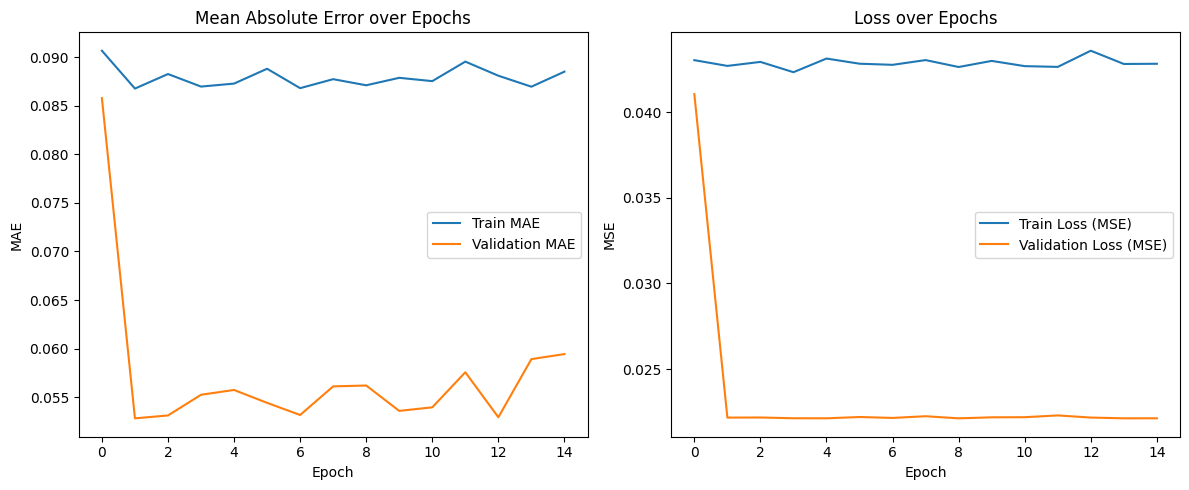

In [ ]:
# Plot MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Plot Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save("Self_model.h5")
print("Model saved as Self_model.h5")


Model saved as Self_model.h5
